<a href="https://colab.research.google.com/github/stemgene/Pytorch_training/blob/master/CNN_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [23]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.5.0


## CNN模型的迁移学习
很多时候当我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型。
这是一种transfer learning的方法。我们常用以下两种方法做迁移学习。
- fine tuning: 从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
- feature extraction: 我们不再改变预训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，利用提取出来的特征做来完成我们的训练任务。

以下是构建和训练迁移学习模型的基本步骤：

- 初始化预训练模型
- 把最后一层的输出层改变成我们想要分的类别总数
- 定义一个optimizer来更新参数
- 模型训练

### 数据
我们会使用hymenoptera_data数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>来读取的格式。我们只需要把data_dir设置成数据的根目录，然后把model_name设置成我们想要使用的与训练模型： :: [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：

- num_classes表示数据集分类的类别数
- batch_size
- num_epochs
- feature_extract表示我们训练的时候使用fine tuning还是feature extraction方法。如果feature_extract = False，整个模型都会被同时更新。如果feature_extract = True，只有模型的最后一层被更新。

In [0]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "/gdrive/My Drive/UR/Programming/hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

input_size = 224

In [0]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))  # random crop a 224 * 224 block from image
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [26]:
img = next(iter(loader))[0] # a tensor
img.shape # batch_size=32

torch.Size([32, 3, 224, 224])

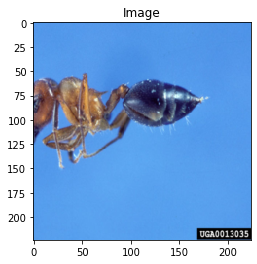

In [27]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)    # convert tensor to image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[1], title='Image')

### Define Model

In [29]:
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [31]:
def set_parameter_requires_grad(model, feature_extract): # if need "fine tuning" set this True, if don't need "fine tuning", set False
  if feature_extract:
    for param in model.parameters():
      param.set_parameter_requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True): # use_pretrained=True can provide a pretrained model
  if model_name == "resnet":
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  else:
    print("model not implemented")
    return None, None
  return model_ft, input_size

# get pretrained model, which full connected layer's output is 2
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
model_ft.fc.weight.requires_grad

True

In [33]:
model_ft.layer1[0].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [34]:
model_ft.layer1[0].conv1.weight.requires_grad

True

### Train model

In [0]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))  # random crop a 224 * 224 block from image
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [0]:
data_transforms = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),

    "val":transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

# get two data loaders
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders_dict = {x:torch.utils.data.DataLoader(image_datasets[x], 
      batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

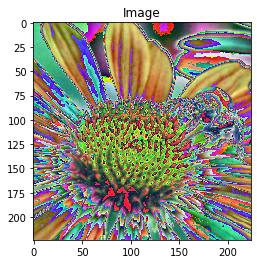

In [37]:
img = next(iter(dataloaders_dict['val']))[0] # this image has been normalized

unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)    # convert tensor to image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
plt.figure()
imshow(img[2], title='Image')

training model

In [0]:
model_ft = model_ft.to(device)

In [0]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.5)
loss_fn = nn.CrossEntropyLoss()

In [0]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"): # if train, have grad, if eval need grad=0, so torch.no_grad
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels) # labels = 0, 1
                    
                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)    
    return model, val_acc_history

In [49]:
_, ohist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.22945595471585384, acc: 0.9139344262295082
Phase val loss: 0.23859968508770263, acc: 0.9281045751633987
Phase train loss: 0.19628600751767394, acc: 0.9262295081967213
Phase val loss: 0.23661556275062312, acc: 0.9215686274509803
Phase train loss: 0.20345642429883362, acc: 0.9426229508196722
Phase val loss: 0.23544445799456704, acc: 0.9281045751633987
Phase train loss: 0.20726363385309937, acc: 0.9221311475409836
Phase val loss: 0.23231908795880338, acc: 0.9215686274509803
Phase train loss: 0.19051521039399943, acc: 0.9549180327868853
Phase val loss: 0.2317530295622894, acc: 0.9281045751633987
Phase train loss: 0.1768656170270482, acc: 0.9590163934426229
Phase val loss: 0.2311679767627342, acc: 0.934640522875817
Phase train loss: 0.20822959942895858, acc: 0.9262295081967213
Phase val loss: 0.22730393094175003, acc: 0.934640522875817
Phase train loss: 0.16052294412597282, acc: 0.9467213114754098
Phase val loss: 0.22436640737882627, acc: 0.934640522875817
Phase train lo

A new model from the begining

In [50]:
model_scratch, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

model_scratch = model_scratch.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_scratch.parameters()), lr=0.001, momentum=0.5)
loss_fn = nn.CrossEntropyLoss()
_, scratch_hist = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.7470513464974575, acc: 0.5286885245901639
Phase val loss: 0.6911017080537634, acc: 0.5098039215686274
Phase train loss: 0.6918165527406286, acc: 0.5286885245901639
Phase val loss: 0.6831609197691375, acc: 0.5424836601307189
Phase train loss: 0.6679058524428821, acc: 0.5983606557377049
Phase val loss: 0.6825713242580688, acc: 0.5424836601307189
Phase train loss: 0.6674748639591405, acc: 0.6065573770491803
Phase val loss: 0.6867014235920377, acc: 0.5294117647058824
Phase train loss: 0.6563613991268346, acc: 0.610655737704918
Phase val loss: 0.6537845002280341, acc: 0.6535947712418301
Phase train loss: 0.6415673963359145, acc: 0.6434426229508197
Phase val loss: 0.6582347135138668, acc: 0.5947712418300654
Phase train loss: 0.6453017475175076, acc: 0.6352459016393442
Phase val loss: 0.6480418424201168, acc: 0.6339869281045751
Phase train loss: 0.6265650420892434, acc: 0.6639344262295082
Phase val loss: 0.6342963369843228, acc: 0.6209150326797386
Phase train loss: 0.62597

plot模型训练时候loss的变化

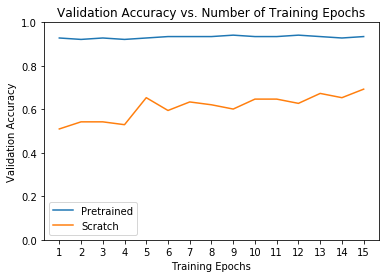

In [51]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

课后学习

- [BERT](https://github.com/huggingface/transformers)
- [ElMo](https://github.com/allenai/allennlp/blob/master/allennlp/modules/elmo.py)
- [Torch Vision Models](https://github.com/pytorch/vision/tree/master/torchvision/models)